# Train-Test splits

In [1]:
import sys
from utils.best_split_utils import *
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
with open("/home/luca/feature_extraction/ember/MOTIF/dataset/motif_dataset.jsonl", "r") as f:
    motif_dataset = [json.loads(line) for line in f.readlines()]

In [3]:
df_motif = pd.DataFrame({
    "md5": [sample["md5"] for sample in motif_dataset],
    "family": [sample["reported_family"] for sample in motif_dataset],
    "first_submission_date": [sample["appeared"] for sample in motif_dataset],
})
df_motif.head()

,md5,family,first_submission_date
0,001d216ee755f0bc96125892e2fb3e3a,shamoon,2018-12
1,006b418307c534754f055436a91848aa,downdelph,2016-10
2,00b35fb5c534dea3ea13c8be4e4585cc,discordiaminer,2017-05
3,00c417425a73db5a315d23fac8cb353f,shamoon,2017-07
4,00cd973ae62f7824dfce7bebda46dcf1,ramnit,2018-10


In [4]:
import os

samples_md5 = os.listdir("/home/luca/feature_extraction/ember/MOTIF/MOTIF/MOTIF_defanged/")
samples_md5 = [s.removeprefix("MOTIF_") for s in samples_md5]

assert set(samples_md5) == set(df_motif["md5"]), "MD5s do not match between dataset and samples"

In [5]:
fsd = "first_submission_date"
# Convert the timestamps to datetime format
df_dt = df_motif.copy()
# df_dt[fsd] = df_dt[fsd].map(lambda t: "4/16/2018" if t == "4/16/208" else t)
df_dt[fsd] = pd.to_datetime(df_dt[fsd], format='%Y-%m')
df_dt.head()

,md5,family,first_submission_date
0,001d216ee755f0bc96125892e2fb3e3a,shamoon,2018-12-01
1,006b418307c534754f055436a91848aa,downdelph,2016-10-01
2,00b35fb5c534dea3ea13c8be4e4585cc,discordiaminer,2017-05-01
3,00c417425a73db5a315d23fac8cb353f,shamoon,2017-07-01
4,00cd973ae62f7824dfce7bebda46dcf1,ramnit,2018-10-01


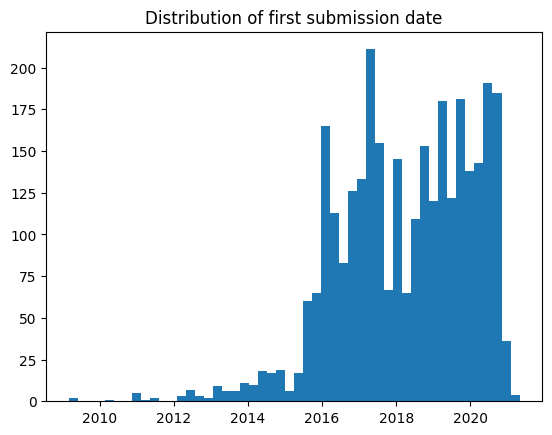

In [6]:
plt.figure()
plt.title("Distribution of first submission date")
plt.hist(df_dt[fsd], bins=50)
plt.show()

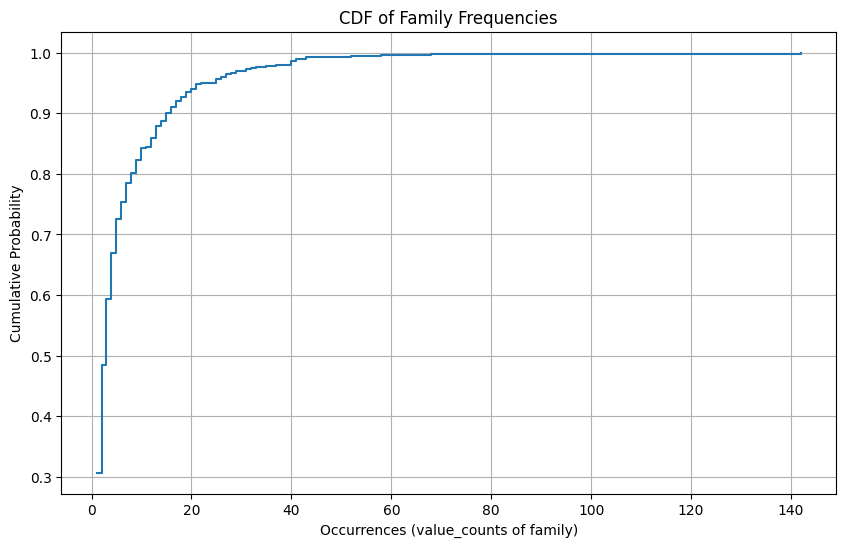

In [7]:
# Get the value counts (frequencies of each family)
freqs = df_dt["family"].value_counts()

# Now get the value counts of those frequencies
freq_counts = freqs.value_counts().sort_index()

# Compute the CDF
x = freq_counts.index.values  # the actual frequency values (e.g., 1, 2, 3...)
y = np.cumsum(freq_counts.values) / freq_counts.values.sum()  # cumulative probability

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.step(x, y, where='post')
plt.xlabel('Occurrences (value_counts of family)')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Family Frequencies')
plt.grid(True)
plt.show()

In [8]:
samples_per_family_count = df_dt["family"].value_counts()
samples_per_family_count = samples_per_family_count[samples_per_family_count >= 10]

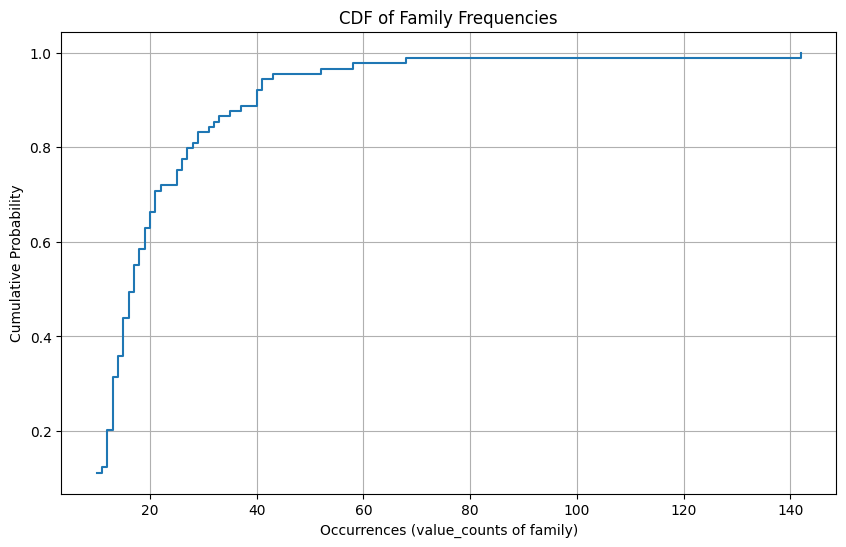

In [9]:
# Get the value counts (frequencies of each family)
df_dt = df_dt[df_dt["family"].isin(samples_per_family_count.index)]
freqs = df_dt["family"].value_counts()

# Now get the value counts of those frequencies
freq_counts = freqs.value_counts().sort_index()

# Compute the CDF
x = freq_counts.index.values  # the actual frequency values (e.g., 1, 2, 3...)
y = np.cumsum(freq_counts.values) / freq_counts.values.sum()  # cumulative probability

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.step(x, y, where='post')
plt.xlabel('Occurrences (value_counts of family)')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Family Frequencies')
plt.grid(True)
plt.show()

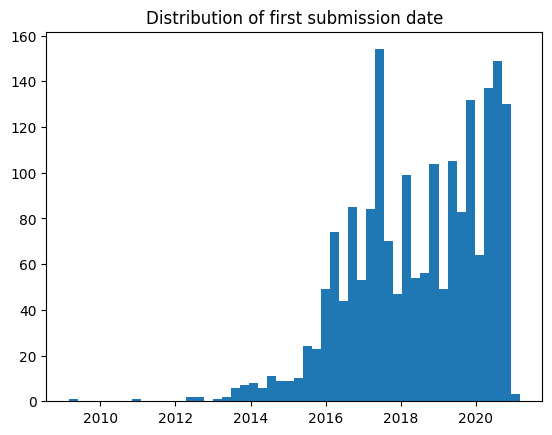

In [10]:
plt.figure()
plt.title("Distribution of first submission date")
plt.hist(df_dt[fsd], bins=50)
plt.show()

In [11]:
df_motif = df_motif[df_motif["family"].isin(samples_per_family_count.index)]
df_motif.shape

(1947, 3)

In [12]:
df_motif.to_csv("./motif_dataset.csv", index=False)

## Choose the Train-Test split by choosing Training set length

Given the length in % of the training set, the dataset is split by the time axis using the bisection method.

In [13]:
def find_balanced_split(training_perc):
    # Sort by time
    df_sorted = df_dt.sort_values(fsd).reset_index(drop=True)
    split_index = int(len(df_sorted) * training_perc)
    
    if split_index >= len(df_sorted):
        raise ValueError("Training percentage results in an empty test set.")
    
    # Get the threshold timestamp
    threshold = df_sorted[fsd].iloc[split_index]
    return threshold

In [14]:
from typing import Callable

def compute_bs_af(df: pd.DataFrame, ref_df: pd.DataFrame, date_split: pd.Timestamp,
                    bs_f: Callable = lambda x: 1 - np.abs(x - 0.7) / 0.7):
    # Train-Test balancing: this score increases as the training test length
    # in % is approaching 70% of the samples
    train_prop = len(df[df[fsd] < date_split]) / len(ref_df)
    
    bs = bs_f(train_prop)

    # % Appearing families in testing set
    df_train_nonzero = split_and_group_nonzero(src_df=df, split_condition=df[fsd] < date_split)
    df_test_nonzero = split_and_group_nonzero(src_df=df, split_condition=df[fsd] >= date_split)

    test_families = df_test_nonzero["family"].unique()
    af = ((len(test_families) - len(np.intersect1d(df_train_nonzero["family"].unique(), test_families))) /
          len(ref_df["family"].unique()))

    return {"bs": bs, "af": af}

In [15]:
def max_train_from_new_f(splits):
    ref_df_dt = df_dt.copy()
    af_f = lambda s: compute_bs_af(df_dt, ref_df_dt, s)["af"]
    ref_af = af_f(splits[0])
    for i in range(1, len(splits)):
        if af_f(splits[i]) < ref_af:
            return splits[i - 1]
    return splits[len(splits) - 1]
        

In [16]:
t_unique = sorted(df_dt[fsd].unique())
date_splits = [t for t in t_unique if min(t_unique) <= t <= max(t_unique)]

In [17]:
df_scores, df_ref_scores = df_dt.copy(), df_dt.copy()
js_scores, perc_app_families, balance_scores = [], [], []
for date_split in date_splits:
    scores = compute_bs_af(df=df_scores, ref_df=df_ref_scores, date_split=date_split)
    perc_app_families.append(scores["af"])
    balance_scores.append(scores["bs"])

In [18]:
# Min-Max normalization
perc_app_families_min_max = ((perc_app_families - np.min(perc_app_families)) /
                             (np.max(perc_app_families) - np.min(perc_app_families)))

balance_scores_min_max = ((balance_scores - np.min(balance_scores)) /
                          (np.max(balance_scores) - np.min(balance_scores)))

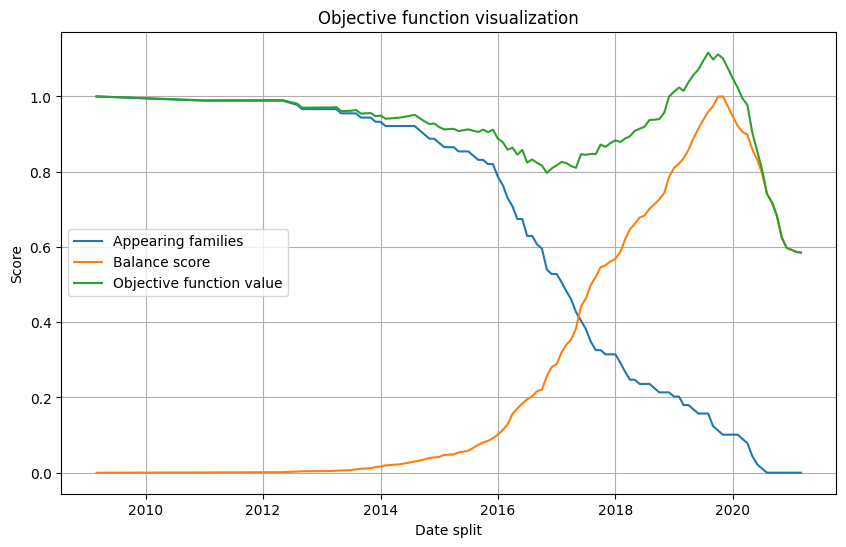

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(date_splits, perc_app_families_min_max, label="Appearing families")
plt.plot(date_splits, balance_scores_min_max, label="Balance score")
plt.plot(date_splits, [bs+af for (bs, af) in zip(perc_app_families_min_max, balance_scores_min_max)], label="Objective function value")

plt.xlabel("Date split")
plt.ylabel("Score")
plt.title("Objective function visualization")
plt.legend()
plt.grid()
plt.show()

In [20]:
f_objective = perc_app_families_min_max + balance_scores_min_max
t_split_mid = date_splits[np.argmax(f_objective)]
print_statistics(df_dt, t_split_mid)

------------------------------------------------------------------
Report: 
	Split at: 2019-08-01 00:00:00
	Training set length: 1278, (65.64%)
	Testing set length: 669, (34.36%)
	Num families in training: 75
	Num families in testing: 43
	Common families: 29
	Families in training but not in testing: 46 (51.69%)
	Families in testing but not in training: 14 (15.73%)
	Training set length (not considering new testing fam): 1278, (79.92%)
	Testing set length (not considering new testing fam): 321, (20.08%)


In [21]:
df_motif[fsd] = pd.to_datetime(df_motif[fsd], format='%Y-%m')

In [22]:
df_motif_train = df_motif[df_motif[fsd] < pd.Timestamp("2019-08-01 00:00:00")]
df_motif_test = df_motif[df_motif[fsd] >= pd.Timestamp("2019-08-01 00:00:00")]

df_motif_train.shape, df_motif_test.shape, df_motif.shape
assert df_motif_train.shape[0] + df_motif_test.shape[0] == df_motif.shape[0], "Train and test sets do not match the original dataset size"

In [23]:
train_family_freq = df_motif_train["family"].value_counts()
train_family_freq = train_family_freq[train_family_freq > 3]

In [24]:
df_motif_train = df_motif_train[df_motif_train["family"].isin(train_family_freq.index)]
df_motif_test = df_motif[~df_motif.index.isin(df_motif_train.index)]

assert df_motif_train.shape[0] + df_motif_test.shape[0] == df_motif.shape[0], "Train and test sets do not match the original dataset size"

In [25]:
df_motif_train.shape[0] / df_motif.shape[0], df_motif_test.shape[0] / df_motif.shape[0]

(0.652799178222907, 0.34720082177709294)

In [26]:
print_statistics_from_train_test(df_motif_train, df_motif_test)

------------------------------------------------------------------
Report: 
	Training set length: 1271, (65.28%)
	Testing set length: 676, (34.72%)
	Num families in training: 72
	Num families in testing: 43
	Common families: 26
	Families in training but not in testing: 46 (51.69%)
	Families in testing but not in training: 17 (19.1%)
	Training set length (not considering new testing fam): 1271, (81.42%)
	Testing set length (not considering new testing fam): 290, (18.58%)
